# Post-Processing Statistical Models in Chapter 6

The models include the following:
* Multilevel model with random intercepts, authoritarianism, and authoritarianism-squared.
* Logit models for voting, multinomial for PID, linear for affective polarization
* Estimated everything in a bayesian framework. 
* $\texttt{brms}$  + $\texttt{tidybayes}$



In [161]:
### Load dependencies, data, themes, configurations
rm(list = ls())
library(brms)
library(ggplot2)
library(modelr)
library(tidybayes)
library(dplyr)
library(cowplot)
library(simplecolors)
library(scales)

setwd("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/Chapter Analysis/Chapter 5 Analysis")
source("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/functions/common_functions.r")

# Updated theme

# ggtheme <- theme(
#         plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 22),
#         axis.text.x = element_text(size = 12, colour = "#535353", face = "bold"),
#         axis.text.y = element_text(size = 12, colour = "#535353", face = "bold"),
#         axis.title = element_text(size = 12, colour = "#535353", face = "bold"),
#         axis.title.y = element_text(size = 12, colour = "#535353", face = "bold", vjust = 1.5),
#         axis.ticks = element_blank(),
#         # change title size
#         strip.text.x = element_text(size = 13), # Increased size for facet labels
#         panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
#         panel.background = element_rect(fill = "white"),
#         legend.text = element_text(size = 12),
#         legend.title = element_text(size = 12),
# )
####

load("vote_model.rda")
load("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/clean_data/pooled.auth.rda")


# Predicted Values, Voting (1992 - 2020)
## The linear model

In this model, there is no quadtric term for authoritarianism. 

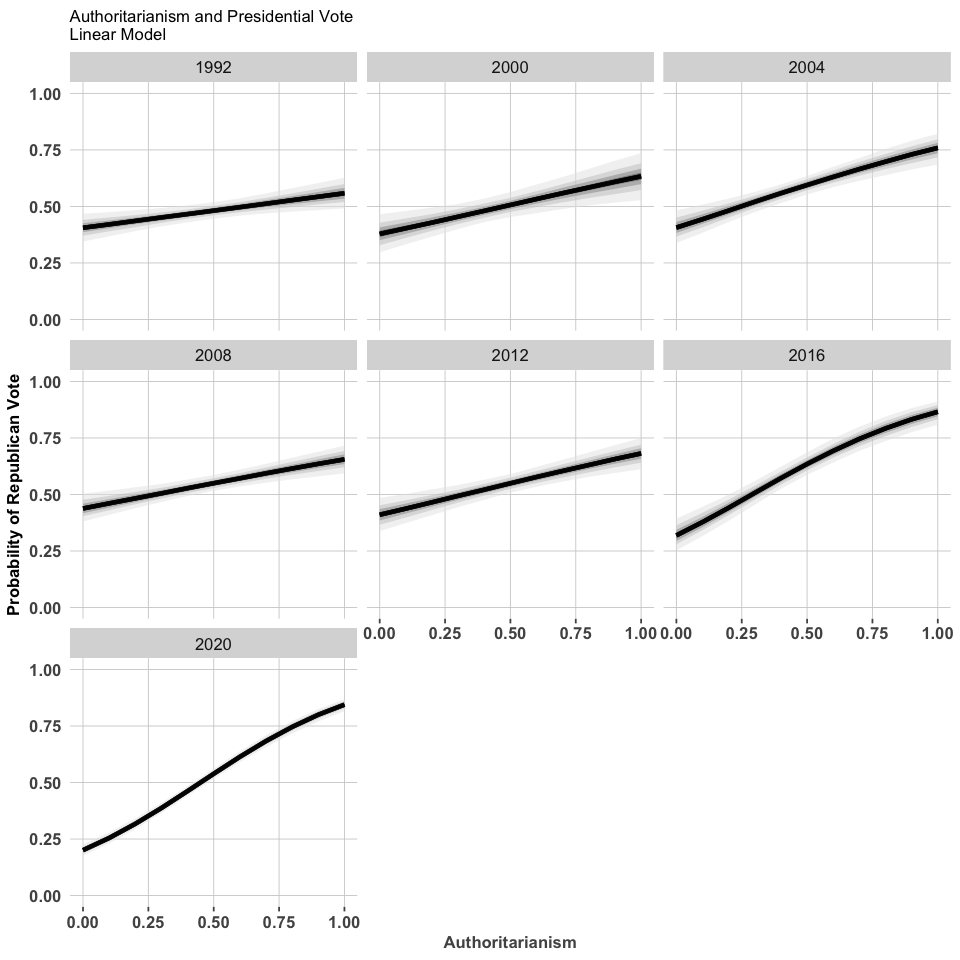

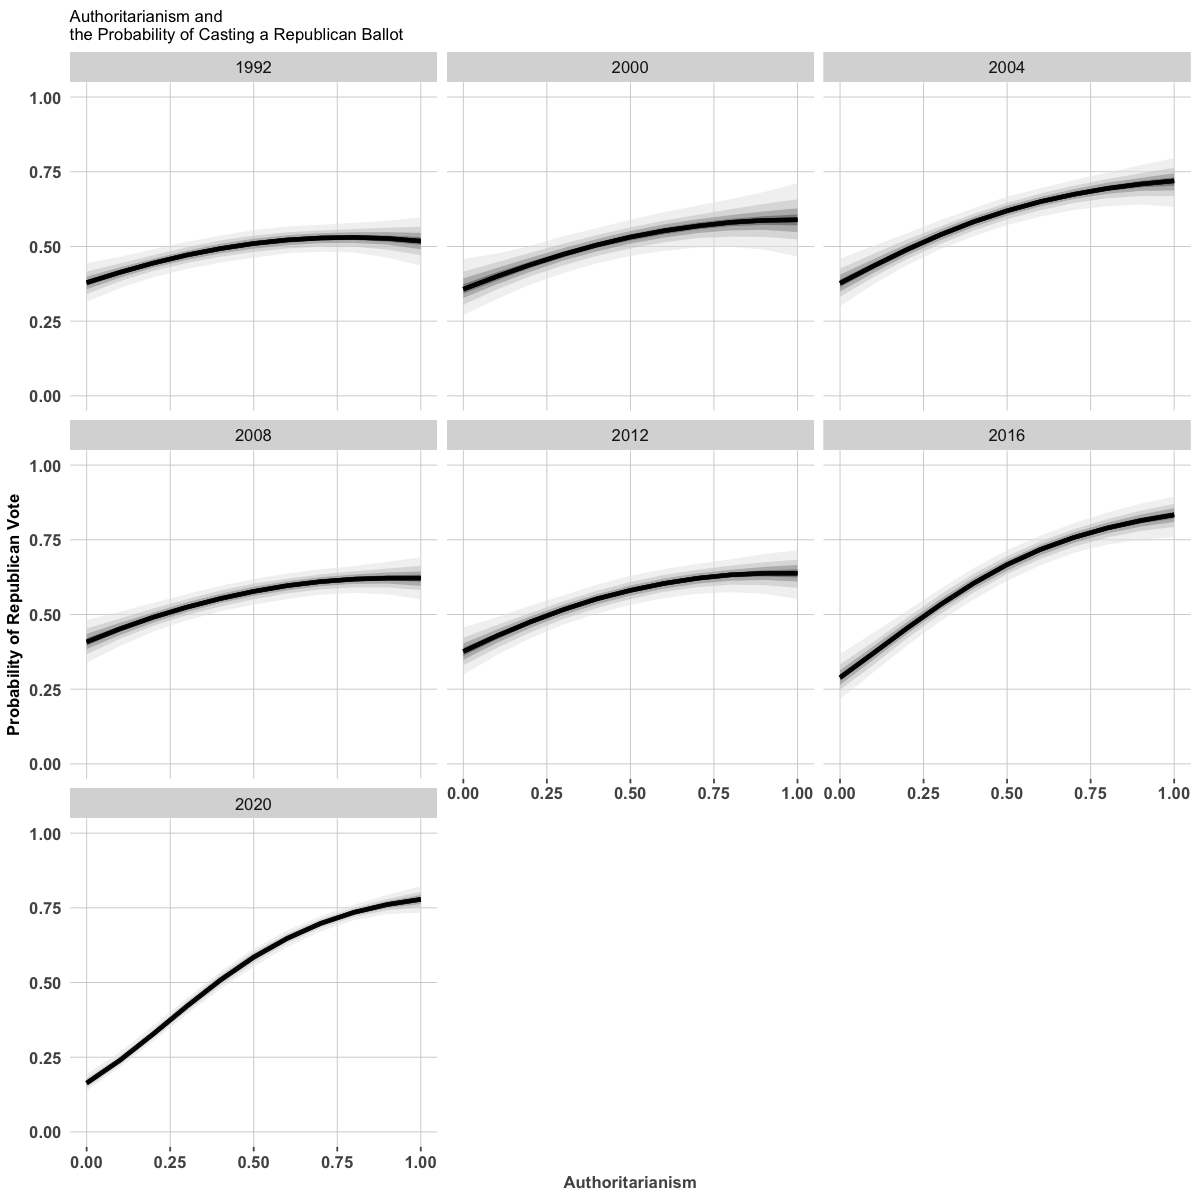

In [162]:
options(repr.plot.width=8, repr.plot.height=8)

## Pull out the relevant models from my output.
fit0b = vote_models[[2]] # Random intercept model saved from models
fit1  = vote_models[[3]] # Random slope mode saved fro model, linear

## Expand the data used to estimate this model
fixed_data = data[,c("vote", "authoritarianism",
                 "female", "age", "college", "income",
                 "jewish", "catholic", "other", "year")] %>% na.omit() %>%
                 mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                group_by(year) %>% data_grid(female = mean(female), age = mean(age),
                                                      college = mean(college), income = mean(income),
                                                      catholic =  mean(catholic), jewish = mean(jewish),
                                                      other = mean(other), authoritarianism = seq_range(authoritarianism, n = 11))  %>%
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism)


m0 = fixed_data %>% add_linpred_draws(fit0b) %>%  mutate(Vote_Republican = plogis(.linpred))  ## Expand posterior



## Plot linear Effects
 m0 %>% ggplot(aes(x = authoritarianism)) + facet_wrap(~year) +
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1),  alpha = 0.5) +
       scale_fill_manual(values = sc_grey(light = 1:5))+
  # Format the grid
  ggtitle("Authoritarianism and Presidential Vote\nLinear Model") +
  scale_y_continuous("Probability of Republican Vote", limits=c(0,1))+
  scale_x_continuous("Authoritarianism") + ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none") %>% suppressWarnings()

m1 <- fixed_data %>%
     add_linpred_draws(fit1) %>%
     mutate(Vote_Republican = plogis(.linpred)) ## Expand posterior

options(repr.plot.width = 10, repr.plot.height = 10)

## Plot linear Effects
m1 %>% ggplot(aes(x = authoritarianism)) +
     facet_wrap(~year) +
     stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1), alpha = 0.5) +
     scale_fill_manual(values = sc_grey(light = 1:5)) +
     # Format the grid
     ggtitle("Authoritarianism and \nthe Probability of Casting a Republican Ballot") +
     scale_y_continuous("Probability of Republican Vote", limits = c(0, 1)) +
     scale_x_continuous("Authoritarianism") +
     ggtheme +
     theme(legend.title = element_blank()) +
     theme(legend.position = "none")

The quadratic specification provides a better fit.

In [163]:
fixed_data %>%
    add_linpred_draws(fit1) %>%
    mutate(Vote_Republican = plogis(.linpred)) %>%
    filter(authoritarianism == 1 | authoritarianism == 0) %>%
    group_by(year, authoritarianism) %>%
    summarize(pred = mean(Vote_Republican))


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


year,authoritarianism,pred
<dbl>,<dbl>,<dbl>
1992,0,0.3783920
1992,1,0.5179691
2000,0,0.3596398
2000,1,0.5892492
2004,0,0.3779783
2004,1,0.7165816
2008,0,0.4092000
2008,1,0.6213500
2012,0,0.3761604


# Cross Validation

What model provides a better fit? A useful way to get at this -- due in part to the non-nested nature of the models -- is "leave-one-out" validation. Basically estimate the model on some subset of the data, predict the model on the "hold-out" data, and compare.  

In [164]:

### linear model (fit0b) ###
fit0a = vote_models[[1]]
fit0b = vote_models[[2]]
fit1  =    vote_models[[3]]

loo(fit0a, fit0b, fit1)

Output of model 'fit0a':

Computed from 1500 by 6023 log-likelihood matrix.

         Estimate   SE
elpd_loo  -3785.9 26.7
p_loo        15.1  0.2
looic      7571.8 53.5
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.7, 1.7]).

All Pareto k estimates are good (k < 0.69).
See help('pareto-k-diagnostic') for details.

Output of model 'fit0b':

Computed from 1500 by 6023 log-likelihood matrix.

         Estimate   SE
elpd_loo  -3716.8 28.6
p_loo        20.8  0.3
looic      7433.6 57.3
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.8, 1.9]).

All Pareto k estimates are good (k < 0.69).
See help('pareto-k-diagnostic') for details.

Output of model 'fit1':

Computed from 1500 by 6023 log-likelihood matrix.

         Estimate   SE
elpd_loo  -3702.8 28.9
p_loo        23.3  0.4
looic      7405.6 57.9
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.3, 1.5]).

All Pareto k estimates 

The quadratic model is a reasonably good improvement over the linear model (fit0b) and substantially better than the random-intercept, authoritarianism-has-a-fixed-effect model (fit0a).

## Marginal Effects

Below are the marginal effects. I'll show the linear effects, but throughout the remaining analysis, I just present the quadratic. As you can see here, there really isn't a large difference

### The Quadratic Variable Specification

In [165]:
### Model to estimate AME
expanded_dat_0 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism   =  quantile(authoritarianism, 0.025)) %>%
                                                      mutate(authoritarianism_2 =  authoritarianism * authoritarianism) %>% data.frame() %>%
                                                      add_linpred_draws(fit1, draws = 1000)   %>%
                                                      mutate(low_auth = .linpred)

expanded_dat_1 = fixed_data %>% group_by(year) %>%       mutate(authoritarianism =  quantile(authoritarianism, 0.975)) %>%
                                                      mutate(authoritarianism_2 =  authoritarianism * authoritarianism) %>% data.frame() %>%
                                                      add_linpred_draws(fit1, draws = 1000)   %>%
                                                      mutate(high_auth = .linpred) %>% select(high_auth)

expanded_dat_0$high_auth = expanded_dat_1$high_auth
expanded_dat_0$marginal = plogis(expanded_dat_0$high_auth) -  plogis(expanded_dat_0$low_auth)

marginals_q = expanded_dat_0   %>% group_by(year) %>% mutate(min              = quantile(marginal, 0.025)) %>%
                                        mutate(med              = quantile(marginal, 0.50)) %>%
                                        mutate(max              = quantile(marginal, 0.975)) %>%
                                        summarize(
                                            min = quantile(min, 0.025),
                                            med = quantile(med, 0.50),
                                            max = quantile(max, 0.975))
marginals_q

Adding missing grouping variables: `year`, `female`, `age`, `college`,
`income`, `catholic`, `jewish`, `other`, `authoritarianism`,
`authoritarianism_2`, `.row`


year,min,med,max
<dbl>,<dbl>,<dbl>,<dbl>
1992,0.03005375,0.1336265,0.2297252
2000,0.06776654,0.2218062,0.3648456
2004,0.20731535,0.3232586,0.4350282
2008,0.10356586,0.2027532,0.3005952
2012,0.13411667,0.2478550,0.3637757
2016,0.41109395,0.5179964,0.6204276
2020,0.54504293,0.5941702,0.6389496


This combined plot forms Figure 1.

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.


pdf 
  2

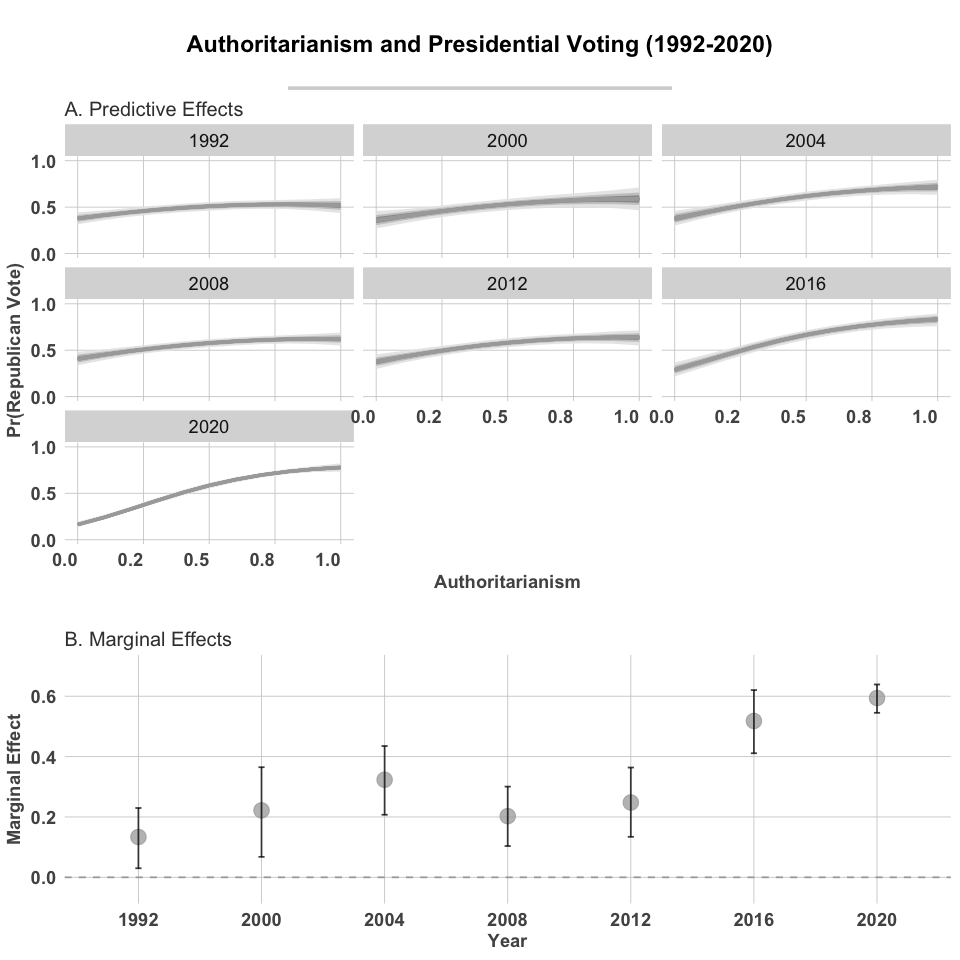

In [166]:
options(repr.plot.width = 8, repr.plot.height = 8)
# Update ggplot theme
ggtheme <- theme(
  plot.title = element_text(hjust = 0, vjust = 0, colour = "#3C3C3C", size = 22),
  axis.text.x = element_text(size = 11, colour = "#535353", face = "bold"),
  axis.text.y = element_text(size = 11, colour = "#535353", face = "bold"),
  axis.title = element_text(size = 11, colour = "#535353", face = "bold"),
  axis.title.y = element_text(size = 11, colour = "#535353", face = "bold", vjust = 1.5),
  axis.ticks = element_blank(),
  # change title size
  strip.text.x = element_text(size = 11), # Increased size for facet labels
  panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
  panel.background = element_rect(fill = "white"),
  legend.text = element_text(size = 11),
  legend.title = element_text(size = 11),
)
# First plot
p1 <- m1 %>% ggplot(aes(x = authoritarianism)) +
  facet_wrap(~year) +
  stat_lineribbon(aes(y = Vote_Republican), .width = c(.95, 0.75, .5, 0.25, 0.1), alpha = 0.9, size = 0.95, color ="darkgrey") +
  scale_fill_manual(values = sc_grey(light = 1:5)) +
  ggtitle("A. Predictive Effects") +
        scale_x_continuous(breaks = seq(0, 1, by = 0.5)) +
  scale_y_continuous("Pr(Republican Vote)", limits = c(0, 1), breaks = seq(0, 1, by = 0.5)) +
  scale_x_continuous("Authoritarianism", labels = number_format(accuracy = 0.1)) +
  ggtheme +
  theme(legend.title = element_blank()) +
  theme(legend.position = "none") +
  theme(axis.text.x = element_text(angle = 0, hjust = 1)) +
  theme(plot.title = element_text(size = 12)) # Smaller title for panel A




# Second plot
p2 <- ggplot(
  data = marginals_q,
  aes(
    x = factor(year),
    y = med, ymin = max,
    ymax = min
  )
) +
  geom_point(size = 4, colour = "darkgrey", alpha = 0.75) +
  geom_errorbar(width = 0.05, alpha = 0.75, colour = "black") +
  ggtitle("B. Marginal Effects") +
  ggtheme +
  scale_y_continuous("Marginal Effect", limits = c(-.05, 0.70)) +
  scale_x_discrete("Year") +
  geom_hline(yintercept = 0, colour = "darkgrey", linetype = "dashed") +
  theme(plot.title = element_text(size = 12)) # Smaller title for panel B

# Combine the plots
combined_plot <- plot_grid(p1, NULL, p2, ncol = 1, rel_heights = c(1.5, 0.05, 1))

# Add a horizontal line between the plots
combined_plot <- ggdraw(combined_plot) +
  draw_line(x = c(0.3, 0.7), y = c(0.999, 0.999), color = "lightgrey", size = 1)

# Add Caption to Combined Plot
caption_text <- "Note.: Predictive and Marginal Effects of Authoritarianism on Republican Vote."

# Add the main title
main_title <- ggdraw() +
  draw_label("Authoritarianism and Presidential Voting (1992-2020)", fontface = "bold", size = 14, x = 0.5, y = 0.5, hjust = 0.5)

# Combine the main title, combined plot, and caption
final_plot <- plot_grid(main_title, combined_plot, ncol = 1, rel_heights = c(0.1, 1))


final_plot
  png("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/images/f5.1.png", width = 6, height = 6, units = "in", res = 400)
  print(final_plot)
  dev.off()


This figure forms Figure 2 in the chapter.

## Education x Authoritarianism 

Disaggregation by education...

In [167]:
## Marginal Effects Function -- adapt to more complicated interactions
fixed <- data[, c(
  "vote", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  na.omit()
marginal_by_ed <- function(fixed = fixed, model_fit = education) {
  out1 <- fixed %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = c(0, 1), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other), authoritarianism = quantile(authoritarianism, 0.025)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100) %>%
    subset(select = .epred)

  out2 <- fixed %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = c(0, 1), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other), authoritarianism = quantile(authoritarianism, .975)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100) %>%
    subset(select = .epred)

  r <- fixed %>%
    na.omit() %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = c(0, 1), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other),
      authoritarianism = quantile(authoritarianism, 0.025)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100)
  r$marginal <- out2$.epred - out1$.epred
  return(r)
}


Here is the predictive plot. I think it's a bit more forceful. The slope is noticeably flatter for the less-educated, particularly pre 2016.

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


pdf 
  2

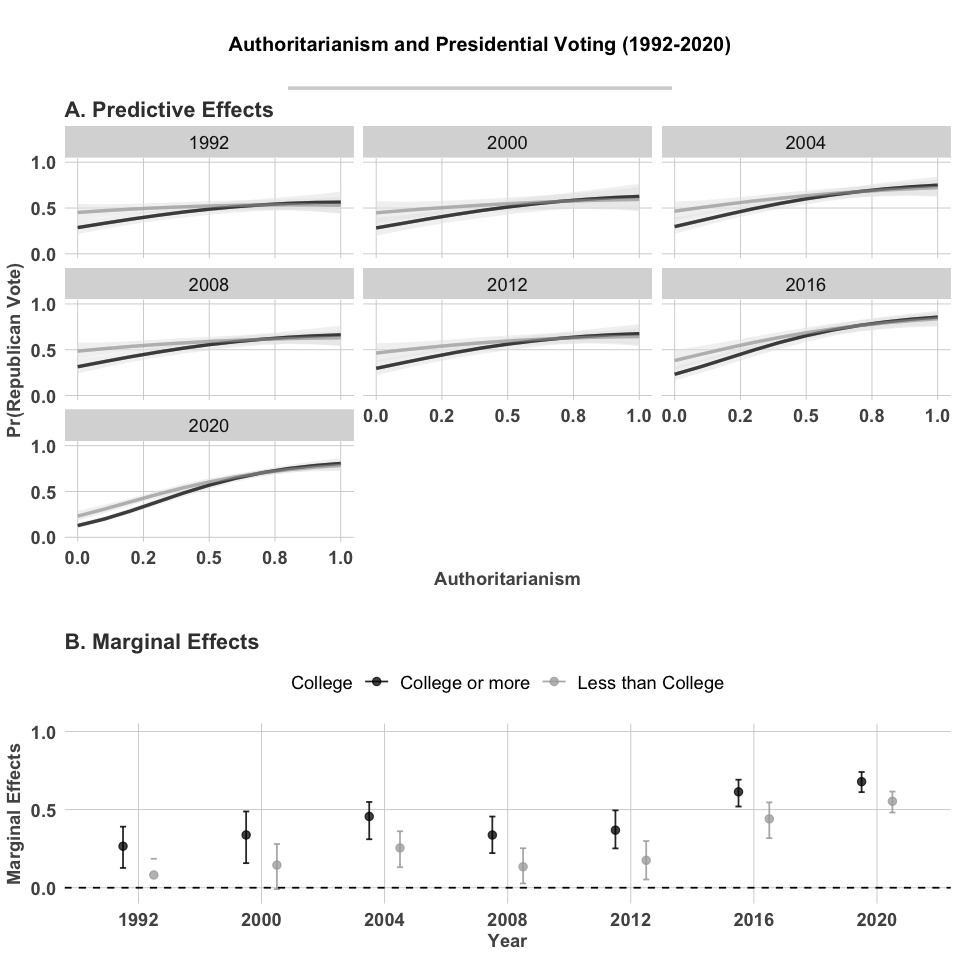

In [218]:
education <- vote_models[[4]]

ggtheme <- theme(
      plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 13),
      axis.text.x = element_text(size = 11, colour = "#535353", face = "bold"),
      axis.text.y = element_text(size = 11, colour = "#535353", face = "bold"),
      axis.title = element_text(size = 11, colour = "#535353", face = "bold"),
      axis.title.y = element_text(size = 11, colour = "#535353", face = "bold", vjust = 1.5),
      axis.ticks = element_blank(),
      # change title size
      strip.text.x = element_text(size = 11), # Increased size for facet labels
      panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
      panel.background = element_rect(fill = "white"),
      legend.text = element_text(size = 11),
      legend.title = element_text(size = 11),
)

fixed_data <- data[, c(
      "vote", "authoritarianism",
      "female", "age", "college", "income",
      "jewish", "catholic", "other", "year"
)] %>%
      na.omit() %>%
      mutate(authoritarianism_2 = authoritarianism * authoritarianism)

model1 <- fixed_data %>%
      group_by(year) %>%
      data_grid(
            female = mean(female), age = mean(age),
            college = c(0, 1), income = mean(income),
            catholic = mean(catholic), jewish = mean(jewish),
            other = mean(other),
            authoritarianism = seq_range(authoritarianism, n = 11)
      ) %>%
      mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
      group_by(year) %>%
      add_linpred_draws(education) %>%
      mutate(Vote_Republican = plogis(.linpred)) %>%
      mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more"))



p1 <- model1 %>%
      ggplot(aes(x = authoritarianism, group = as.factor(Education), color = as.factor(Education))) +
      facet_wrap(~year) +
      stat_lineribbon(aes(y = Vote_Republican), .width = c(.975, 0.025), alpha = 0.5, size = 0.95) +
      scale_fill_manual(values = sc_grey(light = 1:5)) +
      ggtitle("A. Predictive Effects") +
      scale_y_continuous("Pr(Republican Vote)", limits = c(0, 1), breaks = seq(0, 1, by = 0.5)) +
      scale_x_continuous("Authoritarianism", labels = number_format(accuracy = 0.1)) +
      ggtheme +
      # modify legend color
      scale_color_manual(values = c("black", "darkgrey")) +
      theme(legend.position = "none") # Position the legend at the bottom

education <- vote_models[[4]]

p2 <- marginal_by_ed(fixed = fixed) %>%
      mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
      group_by(year, Education) %>%
      mutate(min = quantile(marginal, 0.025)) %>%
      mutate(med = quantile(marginal, 0.50)) %>%
      mutate(max = quantile(marginal, 0.975)) %>%
      summarize(
            min = quantile(min, 0.025),
            med = quantile(med, 0.50),
            max = quantile(max, 0.975)
      ) %>%
      ggplot(aes(
            x = factor(year),
            y = med, ymin = max,
            ymax = min, colour = as.factor(Education), group = as.factor(Education)
      )) +
      geom_point(size = 2, alpha = 0.75, position = position_dodge(width = 0.5)) +
      geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
      ggtitle("B. Marginal Effects") +
      ggtheme +
      scale_y_continuous("Marginal Effects", limits = c(-0.05, 1), breaks = seq(0, 1, by = 0.5)) +
      scale_x_discrete("Year") +
      geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
      scale_colour_manual(name = "College", values = c("black", "darkgrey"))+
      theme(legend.position = "top") # Position the legend at the bottom

# Combine the plots
combined_plot <- plot_grid(p1, NULL, p2, ncol = 1, rel_heights = c(1.2, 0.05, 0.8))

# Add a horizontal line between the plots
combined_plot <- ggdraw(combined_plot) +
      draw_line(x = c(0.3, 0.7), y = c(0.999, 0.999), color = "lightgrey", size = 1)

# Add Caption to Combined Plot
caption_text <- "Note.: Predictive and Marginal Effects of Authoritarianism on Republican Vote."

# Add the main title
main_title <- ggdraw() +
      draw_label("Authoritarianism and Presidential Voting (1992-2020)", fontface = "bold", size = 12, x = 0.5, y = 0.5, hjust = 0.5)

# Combine the main title, combined plot, and caption
final_plot <- plot_grid(main_title, combined_plot,
ncol = 1,
rel_heights = c(0.1, 1))


final_plot
png("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/images/f5.6.png", width = 6, height = 6, units = "in", res = 400)
print(final_plot)
dev.off()


In [170]:
education$data %>% dim()

[1] 6023   11

In [171]:
fixed_data %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = c(0, 1), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 11)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_linpred_draws(education) %>%
  mutate(Vote_Republican = plogis(.linpred)) %>%
  mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
  filter(authoritarianism == 1 | authoritarianism == 0) %>%
  group_by(Education, year, authoritarianism) %>%
  summarize(out = mean(Vote_Republican))

`summarise()` has grouped output by 'Education', 'year'. You can override using
the `.groups` argument.


Education,year,authoritarianism,out
<chr>,<dbl>,<dbl>,<dbl>
College or more,1992,0,0.2875691
College or more,1992,1,0.5635615
College or more,2000,0,0.2848261
College or more,2000,1,0.6255146
College or more,2004,0,0.2991457
College or more,2004,1,0.7470535
College or more,2008,0,0.3158837
College or more,2008,1,0.6600085
College or more,2012,0,0.2981409


# Affective Polarization

Here are the bar plots for our affective analysis plots. 

## Feelings Towards Candidates

In [172]:
options(repr.plot.width = 10, repr.plot.height = 8)
load("affect.rda")
data$party3 <- recode(data$pid * 6 + 1, `1` = 1, `2` = 1, `3` = 2, `4` = 2, `5` = 2, `6` = 3, `7` = 3) %>% suppressWarnings()
data$republican <- recode(data$pid * 6 + 1, `1` = 0, `2` = 0, `3` = 0, `4` = 0, `5` = 0, `6` = 1, `7` = 1) %>% suppressWarnings()
data$democrat <- recode(data$pid * 6 + 1, `1` = 1, `2` = 1, `3` = 0, `4` = 0, `5` = 0, `6` = 0, `7` = 0) %>% suppressWarnings()
data$independent <- recode(data$pid * 6 + 1, `1` = 0, `2` = 0, `3` = 1, `4` = 1, `5` = 1, `6` = 0, `7` = 0) %>% suppressWarnings()
dems <- affect[[1]]
reps <- affect[[2]]
demc <- affect[[3]]
repc <- affect[[4]]

ggtheme <- theme(
  plot.title = element_text(face = "bold", hjust = 0, vjust = 0, colour = "#3C3C3C", size = 10),
  axis.text.x = element_text(size = 10, colour = "#535353", face = "bold"),
  axis.text.y = element_text(size = 10, colour = "#535353", face = "bold"),
  axis.title = element_text(size = 10, colour = "#535353", face = "bold"),
  axis.title.y = element_text(size = 10, colour = "#535353", face = "bold", vjust = 1.5),
  axis.ticks = element_blank(),
  # change title size
  strip.text.x = element_text(size = 10), # Increased size for facet labels
  panel.grid.major = element_line(colour = "#D0D0D0", size = .25),
  panel.background = element_rect(fill = "white"),
  legend.text = element_text(size = 8),
  legend.title = element_text(size = 11),
)

fixed_data <- data[, c(
  "party3", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = mean(college), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism)

data.frame(rbind(
  fixed_data %>% add_linpred_draws(reps, draws = 1000) %>% mutate(.group = "Republicans"),
  fixed_data %>% add_linpred_draws(dems, draws = 1000) %>% mutate(.group = "Democrats"),
  fixed_data %>% add_linpred_draws(repc, draws = 1000) %>% mutate(.group = "Republican Candidate"),
  fixed_data %>% add_linpred_draws(demc, draws = 1000) %>% mutate(.group = "Democratic Candidate")
)) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  group_by(.group, Authoritarianism, year) %>%
  summarise(
    mean = quantile(.linpred, prob = 0.5),
    min = quantile(.linpred, prob = 0.025),
    max = quantile(.linpred, prob = 0.975)
  ) %>%
  as_tibble() %>%
  filter(.group %in% c("Democratic Candidate", "Republican Candidate")) %>%
  ggplot(aes(x = as.factor(year), ymin = min, ymax = max, y = mean, fill = .group), stat = "identity", position = position_dodge()) +
  ggtheme +
  geom_bar(stat = "identity", position = position_dodge()) +
  scale_fill_manual(name = "Presidential Candidate", values = c("lightgrey", "grey")) +
  geom_errorbar(width = .2, position = position_dodge(0.9), alpha = 0.6) +
  facet_wrap(~Authoritarianism, nrow = 2) +
  ggtitle("Presidential Candidates\nA. Predictive Effects") +
  scale_y_continuous("Posterior Prediction", limits = c(0, 0.8), breaks = seq(0, 1, by = 0.5)) +
  ggtheme +
  scale_x_discrete("Year") +
  theme(legend.title = element_blank()) +
  # remove legend
  theme(legend.position = "bottom") -> feelings_candidates


`summarise()` has grouped output by '.group', 'Authoritarianism'. You can
override using the `.groups` argument.


## Feelings Towards Parties

In [173]:
options(repr.plot.width = 10, repr.plot.height = 8)

data.frame(rbind(
  fixed_data %>% add_linpred_draws(reps, draws = 1000) %>% mutate(.group = "Republicans"),
  fixed_data %>% add_linpred_draws(dems, draws = 1000) %>% mutate(.group = "Democrats"),
  fixed_data %>% add_linpred_draws(repc, draws = 1000) %>% mutate(.group = "Republican_Candidate"),
  fixed_data %>% add_linpred_draws(demc, draws = 1000) %>% mutate(.group = "Democratic_Candidate")
)) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  group_by(.group, Authoritarianism, year) %>%
  summarise(
    mean = quantile(.linpred, prob = 0.5),
    min = quantile(.linpred, prob = 0.025),
    max = quantile(.linpred, prob = 0.975)
  ) %>%
  as_tibble() %>%
  filter(.group %in% c("Democrats", "Republicans")) %>%
  ggplot(aes(x = as.factor(year), ymin = min, ymax = max, y = mean, fill = .group), stat = "identity", position = position_dodge()) +
  ggtheme +
  geom_bar(stat = "identity", position = position_dodge()) +
  scale_fill_manual(name = "Party", values = c("lightgrey", "grey")) +
  geom_errorbar(width = .2, position = position_dodge(0.9), alpha = 0.6) +
  facet_wrap(~Authoritarianism, nrow = 2) +
  ggtitle("Political Parties\nA.Predictive Effects") +
  scale_y_continuous("Predicted Score", limits = c(0, 0.8),
   breaks = seq(0, 1, by = 0.5)) +
  scale_x_discrete("Year") +
  theme(legend.title = element_blank()) +
  # remove legend
  theme(legend.position = "bottom")  +
   guides(color = guide_legend(override.aes = list(size = 3))) -> feelings_party



`summarise()` has grouped output by '.group', 'Authoritarianism'. You can
override using the `.groups` argument.


## Data Viz

In [174]:
data.frame(rbind(
  fixed_data %>% add_linpred_draws(reps, draws = 1000) %>% mutate(.group = "Republicans"),
  fixed_data %>% add_linpred_draws(dems, draws = 1000) %>% mutate(.group = "Democrats"),
  fixed_data %>% add_linpred_draws(repc, draws = 1000) %>% mutate(.group = "Republican_Candidate"),
  fixed_data %>% add_linpred_draws(demc, draws = 1000) %>% mutate(.group = "Democratic_Candidate")
)) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  group_by(.group, Authoritarianism, year) %>%
  summarise(
    mean = quantile(.linpred, prob = 0.5),
    min = quantile(.linpred, prob = 0.025),
    max = quantile(.linpred, prob = 0.975)
  ) %>%
  head()


`summarise()` has grouped output by '.group', 'Authoritarianism'. You can
override using the `.groups` argument.


.group,Authoritarianism,year,mean,min,max
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Democratic_Candidate,Authoritarian,1992,0.5600840,0.5276700,0.5917956
Democratic_Candidate,Authoritarian,2000,0.5860251,0.5318416,0.6445460
Democratic_Candidate,Authoritarian,2004,0.4463667,0.4017975,0.4926137
Democratic_Candidate,Authoritarian,2008,0.4791659,0.4430799,0.5123897
Democratic_Candidate,Authoritarian,2012,0.4786061,0.4394003,0.5147530
Democratic_Candidate,Authoritarian,2016,0.2617139,0.2198019,0.3056600


## Marginal Effects

This function calculates the marginal effect, based on data and model.

In [175]:
## Write a function to calculate margins, main effects
margins <- function(fixed = fixed, model_fit) {
  out1 <- fixed %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = mean(college), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other), authoritarianism = min(authoritarianism)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100) %>%
    subset(select = .epred)

  out2 <- fixed %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = mean(college), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other), authoritarianism = max(authoritarianism)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100) %>%
    subset(select = .epred)

  r <- fixed %>%
    na.omit() %>%
    group_by(year) %>%
    data_grid(
      female = mean(female), age = mean(age),
      college = mean(college), income = mean(income),
      catholic = mean(catholic), jewish = mean(jewish),
      other = mean(other),
      authoritarianism = 0
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    add_epred_draws(model_fit, ndraws = 100)
  r$marginal <- out2$.epred - out1$.epred
  return(r)
}


## Marginal Effects for Candidates and Parties

In [176]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot <- data.frame(rbind(
  margins(fixed_data, model_fit = reps) %>%
    group_by(year) %>%
    summarise(
      mean = quantile(marginal, prob = 0.5),
      min = quantile(marginal, prob = 0.025),
      max = quantile(marginal, prob = 0.975)
    ) %>%
    mutate(Party = "Republicans"),
  margins(fixed_data, model_fit = dems) %>%
    group_by(year) %>%
    summarise(
      mean = quantile(marginal, prob = 0.5),
      min = quantile(marginal, prob = 0.025),
      max = quantile(marginal, prob = 0.975)
    ) %>%
    mutate(Party = "Democrats"),
  margins(fixed_data, model_fit = repc) %>%
    group_by(year) %>%
    summarise(
      mean = quantile(marginal, prob = 0.5),
      min = quantile(marginal, prob = 0.025),
      max = quantile(marginal, prob = 0.975)
    ) %>%
    mutate(Party = "Republican_Candidate"),
  margins(fixed_data, model_fit = demc) %>%
    group_by(year) %>%
    summarise(
      mean = quantile(marginal, prob = 0.5),
      min = quantile(marginal, prob = 0.025),
      max = quantile(marginal, prob = 0.975)
    ) %>%
    mutate(Party = "Democratic_Candidate")
)) %>%
  mutate(pid = ifelse(Party == "Republicans" | Party == "Republican_Candidate", "Republican", "Democrat")) %>%
  mutate(candidate = ifelse(Party == "Democratic_Candidate" | Party == "Republican_Candidate", "Candidates", "Parties")) %>%
  filter(.data$candidate == "Candidates") %>%
  ggplot(aes(x = factor(year), y = mean, ymin = min, ymax = max, colour = as.factor(pid), group = as.factor(pid))) +
  geom_point(size = 2, alpha = 0.3, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.2, alpha = 0.9, position = position_dodge(width = 0.5)) +
  ggtitle("B. Marginal Effects") +
  ggtheme +
  scale_y_continuous("Marginal Effect", limits = c(-0.4, 0.6)) +
  scale_x_discrete("Year") +
  ggtheme +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name = "Feeling Thermometer:", values = c("darkgrey", "black")) +
  theme(legend.position = "none")   -> margin_candidates


In [177]:
options(repr.plot.width = 10, repr.plot.height = 8)

plot <- data.frame(rbind(
  margins(fixed_data, model_fit = reps) %>%
    group_by(year) %>%
    summarise(
      mean = quantile(marginal, prob = 0.5),
      min = quantile(marginal, prob = 0.025),
      max = quantile(marginal, prob = 0.975)
    ) %>%
    mutate(Party = "Republicans"),
  margins(fixed_data, model_fit = dems) %>%
    group_by(year) %>%
    summarise(
      mean = quantile(marginal, prob = 0.5),
      min = quantile(marginal, prob = 0.025),
      max = quantile(marginal, prob = 0.975)
    ) %>%
    mutate(Party = "Democrats"),
  margins(fixed_data, model_fit = repc) %>%
    group_by(year) %>%
    summarise(
      mean = quantile(marginal, prob = 0.5),
      min = quantile(marginal, prob = 0.025),
      max = quantile(marginal, prob = 0.975)
    ) %>%
    mutate(Party = "Republican_Candidate"),
  margins(fixed_data, model_fit = demc) %>%
    group_by(year) %>%
    summarise(
      mean = quantile(marginal, prob = 0.5),
      min = quantile(marginal, prob = 0.025),
      max = quantile(marginal, prob = 0.975)
    ) %>%
    mutate(Party = "Democratic_Candidate")
)) %>%
  mutate(pid = ifelse(Party == "Republicans" | Party == "Republican_Candidate", "Republican", "Democrat")) %>%
  mutate(candidate = ifelse(Party == "Democratic_Candidate" | Party == "Republican_Candidate", "Candidates", "Parties")) %>%
  filter(.data$candidate != "Candidates") %>%
  ggplot(aes(x = factor(year), y = mean, ymin = min, ymax = max, colour = as.factor(pid), group = as.factor(pid))) +
  geom_point(size =2, alpha = 0.3, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.20, alpha = 0.9, position = position_dodge(width = 0.5)) +
  ggtitle("B. Marginal Effects") +
  ggtheme +
  scale_y_continuous("Marginal Effect", limits = c(-0.4, 0.6)) +
  scale_x_discrete("Year") +
  ggtheme +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name = "Feeling Thermometer:", values = c("darkgrey", "black")) +
  theme(legend.position = "none") -> margin_parties


Warning message in get_plot_component(plot, "guide-box"):
"Multiple components found; returning the first one. To return all, use `return_all = TRUE`."


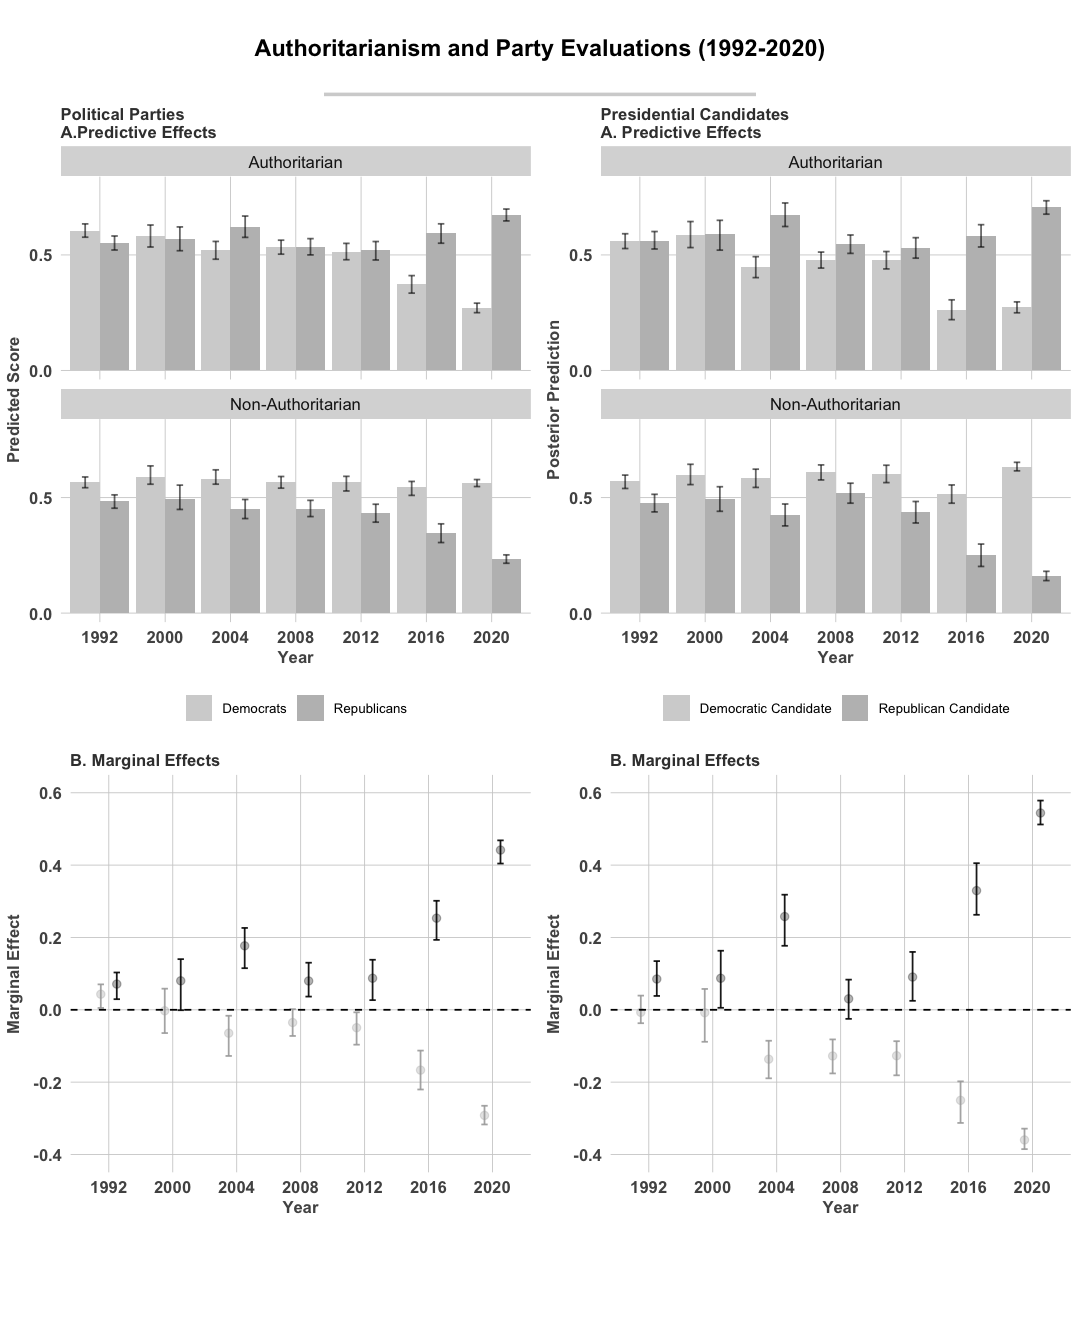

pdf 
  2

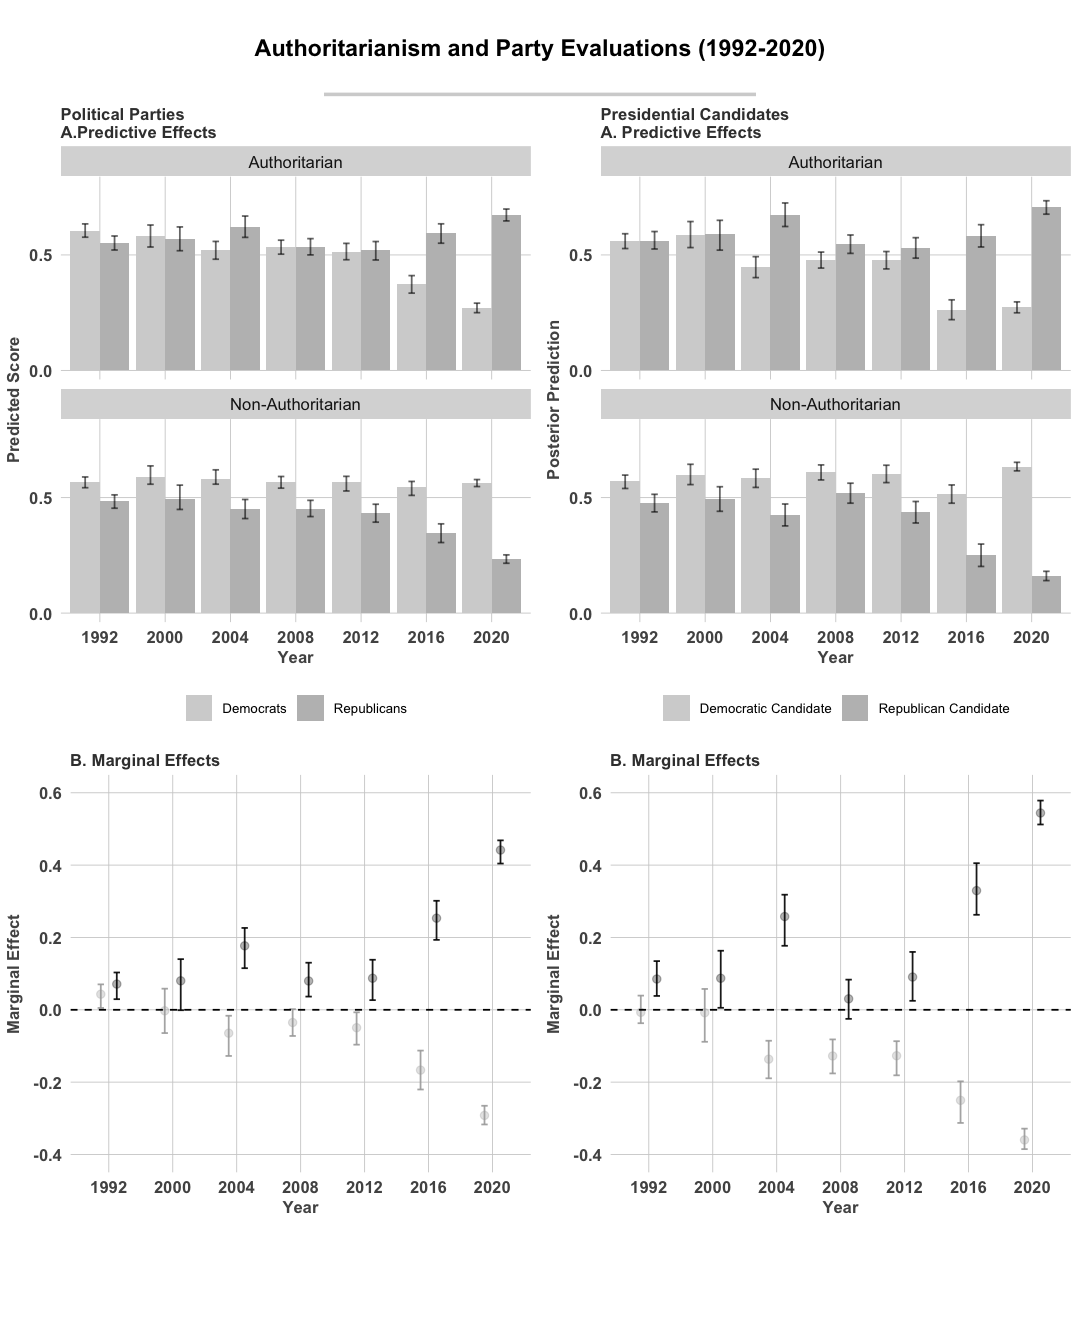

In [178]:
options(repr.plot.width = 9, repr.plot.height = 11)

combined_plot <- plot_grid(feelings_party, feelings_candidates, margin_parties, margin_candidates, ncol = 2, rel_heights = c(1.2, 0.9), rel_widths = c(1, 1))


# Add a horizontal line between the plots
combined_plot <- ggdraw(combined_plot) +
  draw_line(x = c(0.3, 0.7), y = c(0.9999, 0.9999), color = "lightgrey", size = 1)

# Add Caption to Combined Plot
caption_text <- "Note.: Predictive and Marginal Effects of Authoritarianism on Republican Vote."

# Add the main title
main_title <- ggdraw() +
  draw_label("Authoritarianism and Party Evaluations (1992-2020)", fontface = "bold", size = 14, x = 0.5, y = 0.5, hjust = 0.5)


legend <- get_legend(feelings_party + theme(legend.position = "bottom"))

# Combine the main title, combined plot, and caption
final_plot <- plot_grid(
  main_title,
  combined_plot,
  legend,
  ncol = 1,
  rel_heights = c(0.05, 0.6)
)
# Save the plot as a PNG file

final_plot

final_plot
png("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/images/f5.2.png", width = 7, height = 6, units = "in", res = 400)
print(final_plot)
dev.off()


In [95]:
dim(reps$data)
dim(dems$data)
dim(repc$data)
dim(demc$data)

[1] 7788   11

[1] 7788   11

[1] 7788   11

[1] 7788   11

# Point Predictions

The estimates used to generate the tables are displayed below

In [179]:
data.frame(rbind(
    margins(fixed_data, model_fit = reps) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republicans"),
    margins(fixed_data, model_fit = dems) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democrats"),
    margins(fixed_data, model_fit = repc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republican_Candidate"),
    margins(fixed_data, model_fit = demc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democratic_Candidate")
))


year,mean,min,max,Party
<dbl>,<dbl>,<dbl>,<dbl>,<chr>
1992,0.073452966,0.031335564,0.114698676,Republicans
2000,0.075912056,0.012991183,0.146524638,Republicans
2004,0.165741020,0.112129947,0.225549309,Republicans
2008,0.083351104,0.039094704,0.124563332,Republicans
2012,0.089019221,0.038434492,0.139577964,Republicans
2016,0.243758002,0.186175318,0.303852500,Republicans
2020,0.438815329,0.413757297,0.468436042,Republicans
1992,0.041855732,0.002408081,0.075932492,Democrats
2000,-0.008070116,-0.068494958,0.045133994,Democrats


In [180]:
data.frame(rbind(
    margins(fixed_data, model_fit = reps) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republicans"),
    margins(fixed_data, model_fit = dems) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democrats"),
    margins(fixed_data, model_fit = repc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Republican_Candidate"),
    margins(fixed_data, model_fit = demc) %>% group_by(year) %>% summarise(
        mean = quantile(marginal, prob = 0.5),
        min = quantile(marginal, prob = 0.025),
        max = quantile(marginal, prob = 0.975)
    ) %>% mutate(Party = "Democratic_Candidate")
)) %>%
    mutate(pid = ifelse(Party == "Republicans" | Party == "Republican_Candidate", "Republican", "Democrat")) %>%
    mutate(candidate = ifelse(Party == "Democratic_Candidate" | Party == "Republican_Candidate", "Candidate", "Party"))


year,mean,min,max,Party,pid,candidate
<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1992,0.06904644,0.021854188,0.110956961,Republicans,Republican,Party
2000,0.07164672,0.002266305,0.142310546,Republicans,Republican,Party
2004,0.17065611,0.102281841,0.223842967,Republicans,Republican,Party
2008,0.08267442,0.037533319,0.114331451,Republicans,Republican,Party
2012,0.08335335,0.034577787,0.131514247,Republicans,Republican,Party
2016,0.24598285,0.186233650,0.306520029,Republicans,Republican,Party
2020,0.43981420,0.409180179,0.467159362,Republicans,Republican,Party
1992,0.03758531,-0.006898387,0.067742925,Democrats,Democrat,Party
2000,-0.01457177,-0.067870637,0.043421715,Democrats,Democrat,Party


I did change this figure a bit. Let me know what you think. It seems particularly striking with everything on one plot.

# Education and Affective Polarization

Here are calculate the effects of authoritarianism for REP FT - DEM FT and REP CAND FT - DEM CAND FT

In [181]:
options(repr.plot.width = 15, repr.plot.height = 15)

difference <- affect[[5]]
fixed_data %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = c(0, 1), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_linpred_draws(difference) %>%
  mutate(Feeling = .linpred) %>%
  mutate(Education = recode(college,
    `0` = "Less than College",
    `1` = "College or more"
  )) %>%
  group_by(Education, authoritarianism, year) %>%
  summarise(
    mean = quantile(Feeling, prob = 0.5),
    min = quantile(Feeling, prob = 0.025),
    max = quantile(Feeling, prob = 0.975)
  )


`summarise()` has grouped output by 'Education', 'authoritarianism'. You can
override using the `.groups` argument.


Education,authoritarianism,year,mean,min,max
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
College or more,0,1992,-0.166859842,-0.22558303,-0.1070816524
College or more,0,2000,-0.193666487,-0.26595339,-0.1161209267
College or more,0,2004,-0.224714113,-0.28774623,-0.1592205522
College or more,0,2008,-0.194033491,-0.25896486,-0.1380510140
College or more,0,2012,-0.204311666,-0.26968295,-0.1398269198
College or more,0,2016,-0.251014628,-0.31384474,-0.1899059410
College or more,0,2020,-0.394546346,-0.42655327,-0.3606940503
College or more,1,1992,0.012572084,-0.07233933,0.0908334571
College or more,1,2000,0.067967872,-0.03588842,0.1741717448


In [182]:
difference$data %>% dim()

[1] 7788   13

`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


[1] 7788   13

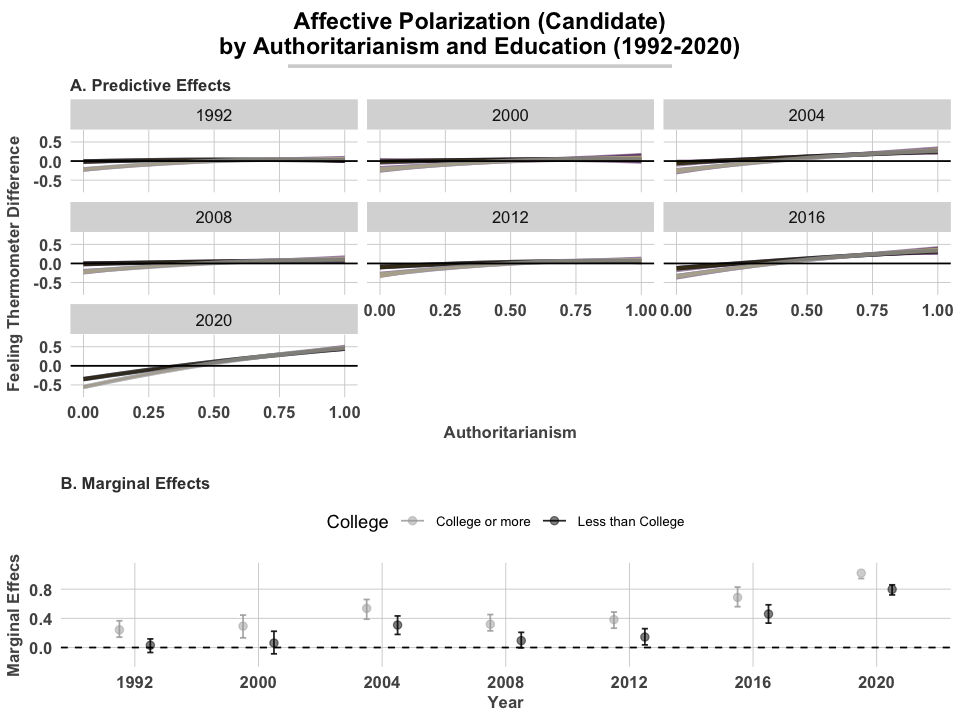

pdf 
  2

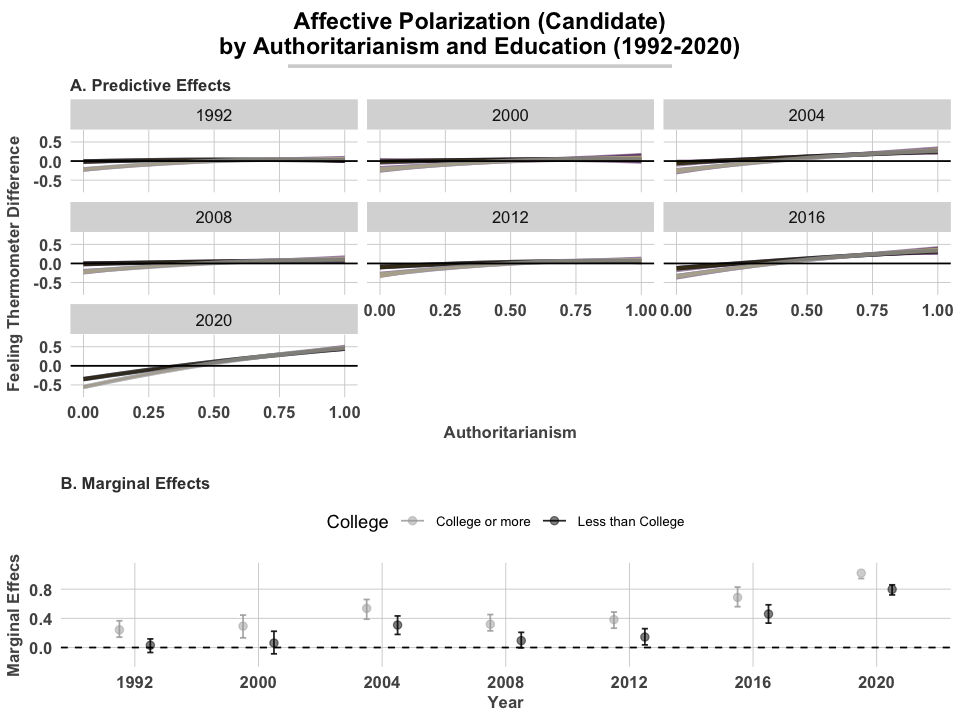

In [199]:
options(repr.plot.width = 8, repr.plot.height = 6)

difference <- affect[[6]]
fixed_data %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = c(0, 1), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 11)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_linpred_draws(difference) %>%
  mutate(Feeling = .linpred) %>%
  mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
  ggplot(aes(x = authoritarianism, group = Education, colour = as.factor(Education))) +
  facet_wrap(~year) +
  stat_lineribbon(aes(y = Feeling), .width = c(.95, 0.75), alpha = 0.5) +
  ggtheme +
  geom_hline(yintercept = 0) +
  # Format the grid
  ggtitle("A. Predictive Effects") +
  scale_y_continuous("Feeling Thermometer Difference",  limits = c(-0.75, 0.75) ,
    breaks = seq(-1, 1, by = 0.5)
  ) +    scale_x_continuous("Authoritarianism") +
  scale_colour_manual(name = "College", values = c("darkgrey", "black")) +
  theme(legend.position = "none") -> p1




marginal_by_ed(fixed = fixed, model_fit = difference) %>%
  group_by(year, college) %>%
  mutate(min = quantile(marginal, 0.025)) %>%
  mutate(med = quantile(marginal, 0.50)) %>%
  mutate(max = quantile(marginal, 0.975)) %>%
  summarize(
    min = quantile(min, 0.025),
    med = quantile(med, 0.50),
    max = quantile(max, 0.975)
  ) %>%
  mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
  ggplot(aes(
    x = factor(year),
    y = med, ymin = max,
    ymax = min, colour = as.factor(Education), group = as.factor(Education)
  )) +
  geom_point(size = 2, alpha = 0.5, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
  ggtitle("B. Marginal Effects") +
  ggtheme +
  scale_y_continuous("Marginal Effecs", limits = c(-0.2, 1.1)) +
  scale_x_discrete("Year") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name = "College", values = c("darkgrey", "black")) +
  theme(legend.position = "top") -> p2



# Combine the plots
combined_plot <- plot_grid(p1, NULL, p2, ncol = 1, rel_heights = c(1.5, 0.05, 1))

# Add a horizontal line between the plots
combined_plot <- ggdraw(combined_plot) +
  draw_line(x = c(0.3, 0.7), y = c(0.999, 0.999), color = "lightgrey", size = 1)

# Add Caption to Combined Plot
caption_text <- "Note.: Predictive and Marginal Effects of Authoritarianism on Republican Vote."

# Add the main title
main_title <- ggdraw() +
  draw_label("Affective Polarization (Candidate)\nby Authoritarianism and Education (1992-2020)", fontface = "bold", size = 14, x = 0.5, y = 0.5, hjust = 0.5)

# Combine the main title, combined plot, and caption
final_plot <- plot_grid(main_title, combined_plot,
  ncol = 1,
  rel_heights = c(0.1, 1)
)


final_plot




difference$data %>% dim()
final_plot
png("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/images/f5.7.png", width = 7, height = 6, units = "in", res = 400)
print(final_plot)
dev.off()

In [200]:
  fixed_data %>% group_by(year) %>% data_grid(female = mean(female), age = mean(age),
                                                      college = c(0,1), income = mean(income),
                                                      catholic =  mean(catholic), jewish = mean(jewish),
                                                      other = mean(other),
                                                      authoritarianism = seq_range(authoritarianism, n = 11)) %>%
                                                      mutate(authoritarianism_2 = authoritarianism*authoritarianism) %>%
                                                      group_by(year) %>%
                                                      add_linpred_draws(education) %>%
                                                      mutate(Vote_Republican = plogis(.linpred))  %>%
                                        mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more"))  %>%
                                        filter(authoritarianism ==1 | authoritarianism ==0) %>%
                                        group_by(Education, year, authoritarianism) %>% summarize(out = mean(Vote_Republican))

`summarise()` has grouped output by 'Education', 'year'. You can override using
the `.groups` argument.


Education,year,authoritarianism,out
<chr>,<dbl>,<dbl>,<dbl>
College or more,1992,0,0.2870638
College or more,1992,1,0.5629549
College or more,2000,0,0.2816886
College or more,2000,1,0.6219108
College or more,2004,0,0.2986706
College or more,2004,1,0.7466221
College or more,2008,0,0.3157154
College or more,2008,1,0.6598305
College or more,2012,0,0.2967053


`summarise()` has grouped output by 'year'. You can override using the
`.groups` argument.


pdf 
  2

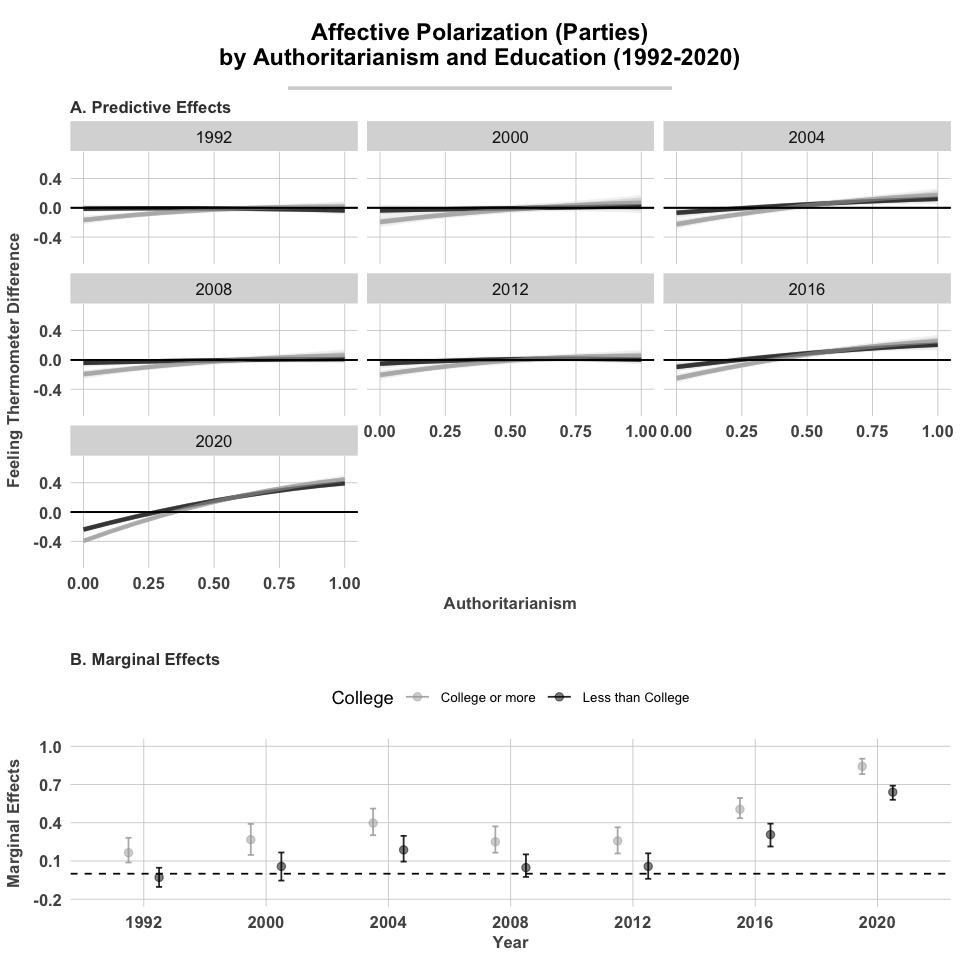

In [202]:
options(repr.plot.width = 10, repr.plot.height = 10)

extremity2 <- affect[[5]]

fixed_data %>%
    group_by(year) %>%
    data_grid(
        female = mean(female), age = mean(age),
        college = c(0, 1), income = mean(income),
        catholic = mean(catholic), jewish = mean(jewish),
        other = mean(other),
        authoritarianism = seq_range(authoritarianism, n = 11)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    group_by(year) %>%
    add_linpred_draws(extremity2) %>%
    mutate(Feeling = .linpred) %>%
    mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
    ggplot(aes(x = authoritarianism, group = Education, colour = as.factor(Education))) +
    facet_wrap(~year) +
    stat_lineribbon(aes(y = Feeling), .width = c(.95, 0.75), alpha = 0.5) +
    ggtheme +
    geom_hline(yintercept = 0) +
    geom_hline(yintercept = 0) +
    scale_fill_manual(name = "Credibility Interval", values = sc_grey(light = 1:2)) +
    # Format the grid
    ggtitle("A. Predictive Effects") +
    scale_y_continuous("Feeling Thermometer Difference", limits = c(-0.7, 0.7)) +
    scale_x_continuous("Authoritarianism") +
    scale_colour_manual(name = "College", values = c("darkgrey", "black")) +
    theme(legend.position = "none") -> p1


marginal_by_ed(fixed = fixed, model_fit = extremity2) %>%
    group_by(year, college) %>%
    mutate(min = quantile(marginal, 0.025)) %>%
    mutate(med = quantile(marginal, 0.50)) %>%
    mutate(max = quantile(marginal, 0.975)) %>%
    summarize(
        min = quantile(min, 0.025),
        med = quantile(med, 0.50),
        max = quantile(max, 0.975)
    ) %>%
    mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
    ggplot(aes(
        x = factor(year),
        y = med, ymin = max,
        ymax = min, colour = as.factor(Education), group = as.factor(Education)
    )) +
    geom_point(size = 2, alpha = 0.5, position = position_dodge(width = 0.5)) +
    geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
    ggtitle("B. Marginal Effects") +
    ggtheme +
    scale_y_continuous("Marginal Effects", limits = c(-0.2, 1),
                        breaks = seq(-.2, 1, by = 0.3)) +
                            scale_x_discrete("Year") +
    geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
    scale_colour_manual(name = "College", values = c("darkgrey", "black")) +
      theme(legend.position = "top") -> p2



# Combine the plots
combined_plot <- plot_grid(p1, NULL, p2, ncol = 1, rel_heights = c(1.5, 0.05, 0.9))

# Add a horizontal line between the plots
combined_plot <- ggdraw(combined_plot) +
    draw_line(x = c(0.3, 0.7), y = c(0.999, 0.999), color = "lightgrey", size = 1)

# Add Caption to Combined Plot
caption_text <- "Note.: Predictive and Marginal Effects of Authoritarianism on Republican Vote."

# Add the main title
main_title <- ggdraw() +
    draw_label("Affective Polarization (Parties)\nby Authoritarianism and Education (1992-2020)", fontface = "bold", size = 14, x = 0.5, y = 0.5, hjust = 0.5)

# Combine the main title, combined plot, and caption
final_plot <- plot_grid(main_title, combined_plot,
    ncol = 1,
    rel_heights = c(0.1, 1)
)


options(repr.plot.width = 8, repr.plot.height = 8)



final_plot
png("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/images/f5.8.png", width = 7, height = 6, units = "in", res = 400)
print(final_plot)
dev.off()

Things do seem to change in 2016, 2020. There's really no effect of authoritarianism on affective polarization among non-college educated respondents before 2016

## Partisanship and Authoritarian Sorting

[1] 8012   11

pdf 
  2

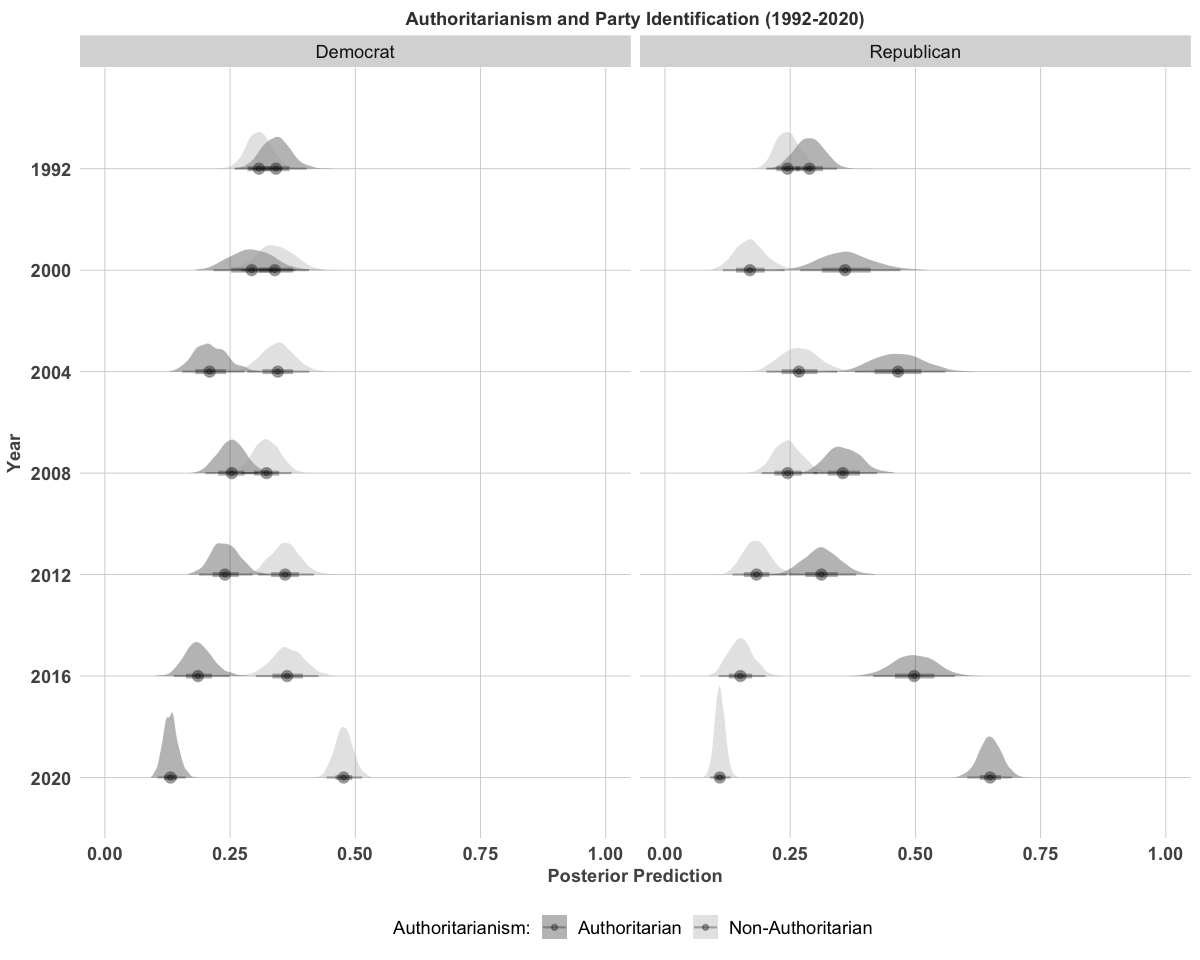

In [219]:
library(tidybayes)
options(repr.plot.width = 10, repr.plot.height = 8)
load("party_model.rda")
party <- party_model[[2]]
data[, c(
  "party3", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = mean(college), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_epred_draws(party) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican")) %>%
  subset(.category != 2) %>%
  ggplot(aes(
    x = .epred, y = as.factor(year),
    group = as.factor(authoritarianism), fill = Authoritarianism
  )) +
  facet_wrap(~PID) +
  stat_halfeye(alpha = 0.3) +
  ggtheme +
  # Format the grid
  ggtitle("Authoritarianism and Party Identification (1992-2020)") +
  scale_x_continuous("Posterior Prediction", limits = c(0, 1)) +
  scale_y_discrete("Year", limits = rev) +
  scale_fill_manual(name = "Authoritarianism:", values = c("black", "darkgrey")) +
  theme(
    legend.position = "bottom",
    plot.title = element_text(size = 11, face = "bold", hjust = 0.5, vjust = 0.5),
  ) -> final_plot
dim(party_model[[2]]$data)

final_plot
png("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/images/f5.3.png", width = 6, height = 6, units = "in", res = 400)
print(final_plot)
dev.off()

In [204]:
data[, c(
  "party3", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = mean(college), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  add_epred_draws(party) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican")) %>%
  subset(.category != 2) %>%
  group_by(.category, Authoritarianism, year) %>%
  summarise(
    mean = quantile(.epred, prob = 0.5),
    min = quantile(.epred, prob = 0.025),
    max = quantile(.epred, prob = 0.975)
  )


`summarise()` has grouped output by '.category', 'Authoritarianism'. You can
override using the `.groups` argument.


.category,Authoritarianism,year,mean,min,max
<fct>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,Authoritarian,1992,0.3415358,0.28730826,0.4028110
1,Authoritarian,2000,0.2930504,0.21672069,0.3803237
1,Authoritarian,2004,0.2089945,0.15463571,0.2782813
1,Authoritarian,2008,0.2534124,0.20089170,0.3057794
1,Authoritarian,2012,0.2397784,0.18809961,0.2947598
1,Authoritarian,2016,0.1858599,0.13768385,0.2489083
1,Authoritarian,2020,0.1310938,0.10535127,0.1615295
1,Non-Authoritarian,1992,0.3076256,0.25952508,0.3555469
1,Non-Authoritarian,2000,0.3392419,0.27206079,0.4076603


In [223]:
options(repr.plot.width = 13, repr.plot.height = 10)

partyXed <- party_model[[1]]
data[, c(
  "party3", "authoritarianism",
  "female", "age", "college", "income",
  "jewish", "catholic", "other", "year"
)] %>%
  na.omit() %>%
  group_by(year) %>%
  data_grid(
    female = mean(female), age = mean(age),
    college = c(0, 1), income = mean(income),
    catholic = mean(catholic), jewish = mean(jewish),
    other = mean(other),
    authoritarianism = seq_range(authoritarianism, n = 2)
  ) %>%
  mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
  group_by(year) %>%
  add_epred_draws(partyXed) %>%
  mutate(Authoritarianism = recode(authoritarianism, `0` = "Non-Authoritarian", `1` = "Authoritarian")) %>%
  mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican")) %>%
  mutate(Education = recode(college, `0` = "Less than College", `1` = "College or more")) %>%
  subset(.category != 2) %>%
  ggplot(aes(
    x = .epred, y = as.factor(year),
    group = as.factor(authoritarianism),
    fill = Authoritarianism
  )) +
  facet_wrap(~ PID + Education ) +
  stat_halfeye(alpha = 0.5, size = 2) +
  ggtheme +
  # Format the grid
  ggtitle("Party Identification,\nBy Education and Authoritarianism") +
  scale_x_continuous("Posterior Predictive Distributions", limits = c(0, 1)) +
  scale_y_discrete("Year", limits = rev) +
  scale_fill_manual(name = "Authoritarianism", values = c("black", "darkgrey")) +
  theme(plot.title = element_text(size = 12, face = "bold", hjust = 0.5, vjust = 0.5), )  +
  theme(legend.position = "bottom") -> final_plot


png("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/images/f5.9.png", width = 6, height = 6, units = "in", res = 400)
print(final_plot)
dev.off()


pdf 
  2

The effect of authoritarianism among the on-college educated only begin to emerge in 2016. Here's another interesting graph. Authoritarianism has a relatively flat effect in 2012, 2008.


Warning message in layer_slabinterval(data = data, mapping = mapping, stat = StatLineribbon, :
"Ignoring unknown parameters: `size`"


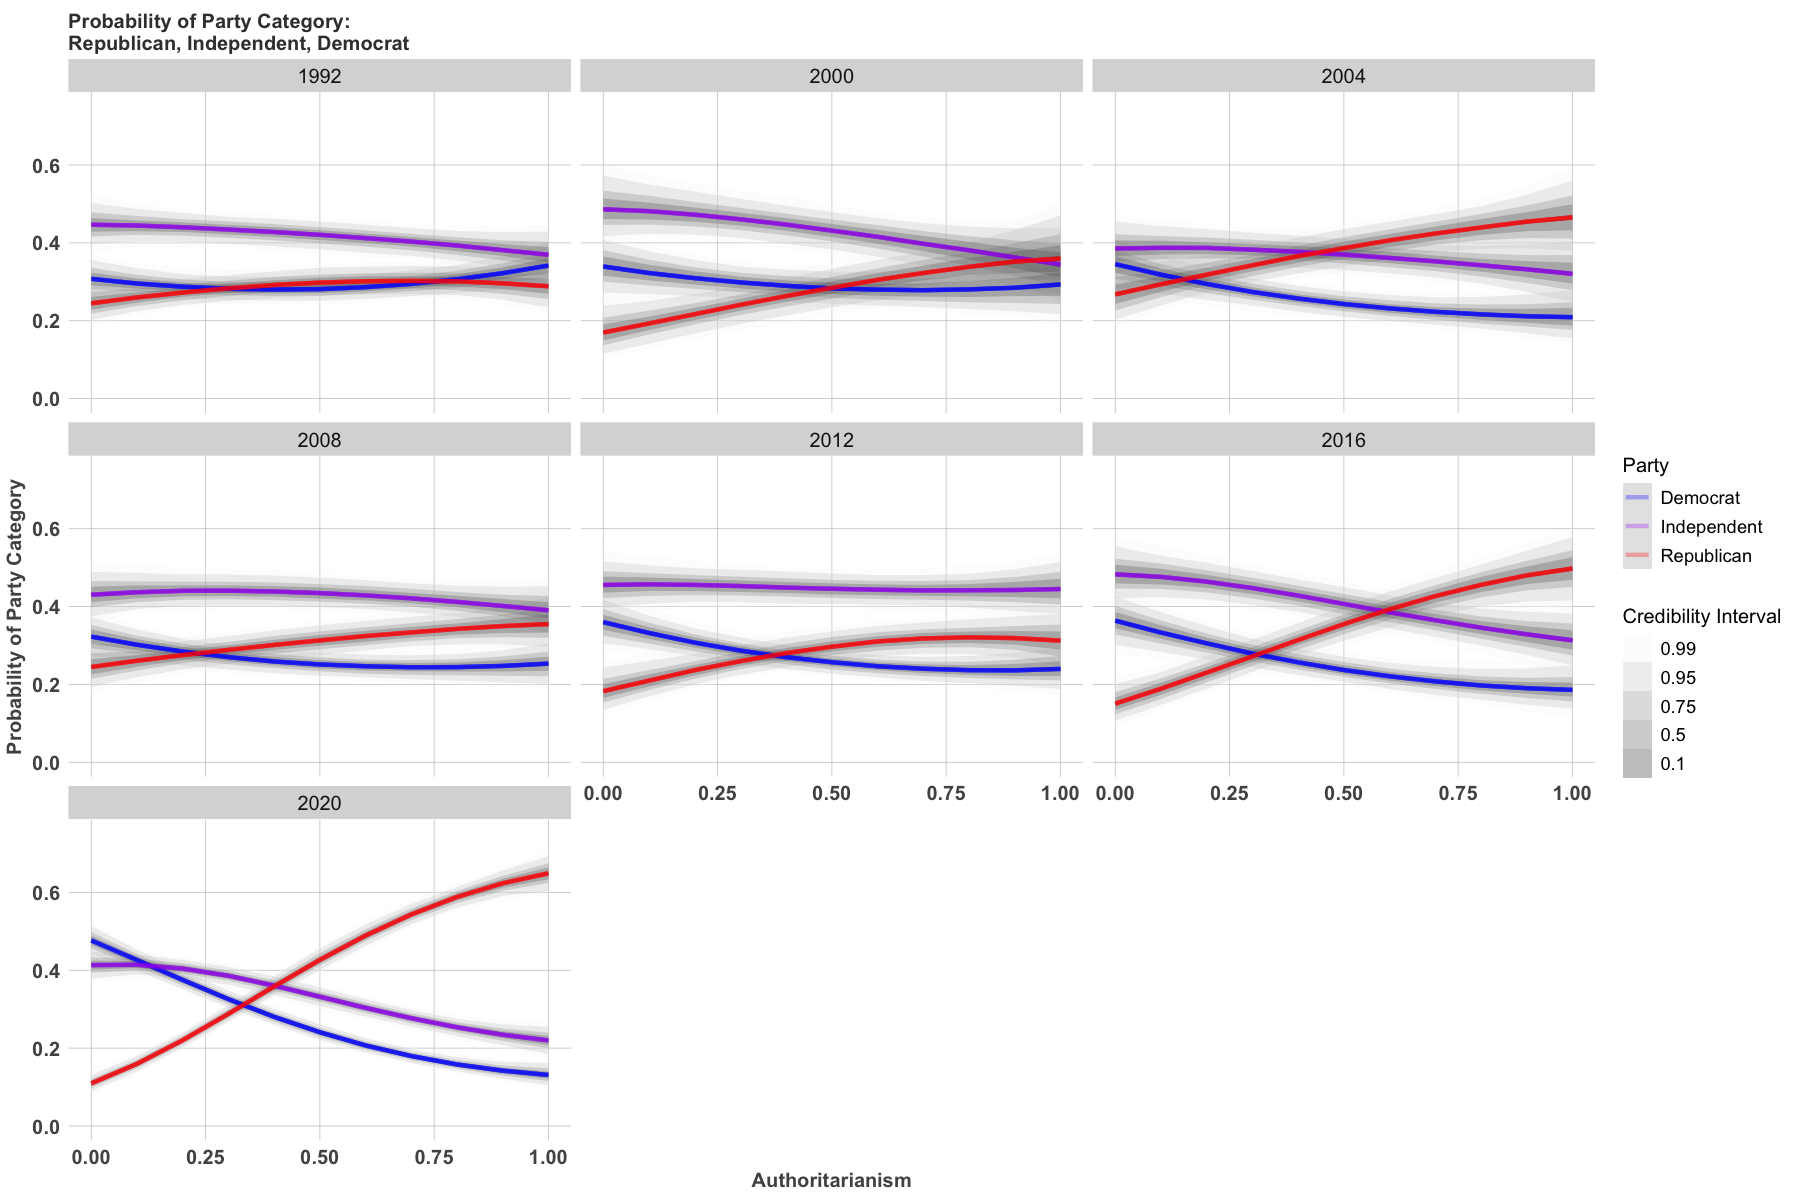

In [251]:
options(repr.plot.width = 15, repr.plot.height = 10)

fixed_data %>%
    group_by(year) %>%
    data_grid(
        female = mean(female), age = mean(age),
        college = mean(college), income = mean(income),
        catholic = mean(catholic), jewish = mean(jewish),
        other = mean(other),
        authoritarianism = seq_range(authoritarianism, n = 11)
    ) %>%
    mutate(authoritarianism_2 = authoritarianism * authoritarianism) %>%
    group_by(year) %>%
    add_epred_draws(party) %>%
    mutate(PID = recode(.category, `1` = "Democrat", `2` = "Independent", `3` = "Republican")) %>%
    #       subset(.category != 2)  %>%
    ggplot(aes(x = authoritarianism, color = PID)) +
    facet_wrap(~year) +
    stat_lineribbon(aes(y = .epred), .width = c(.1, .5, 0.75, 0.95, 0.99), size = 0.5, alpha = 0.3) +
    scale_color_manual(name = "Party", values = c("blue", "purple", "red")) +
    ggtheme +
    scale_fill_brewer(name = "Credibility Interval", palette = "Greys") +

    # Format the grid
    ggtitle("Probability of Party Category:\nRepublican, Independent, Democrat") +
    scale_y_continuous("Probability of Party Category", limits = c(0, 0.75)) +
    scale_x_continuous("Authoritarianism")


Authoritarians clearly shift to the Republican Party, but really only in 2004, and then again in 2016, 2020.

# Mediation and Moderation

In [216]:
load("indirect.rda")
plt <- output[[1]] %>% as.data.frame()
plt$type <- ifelse(grepl("^NIE", row.names(plt)), "Indirect", "Direct")
plt$party <- ifelse(grepl("*_0", row.names(plt)), "Democratic Voter", "Republican Voter")
plt$year <- rep(c(1992, 2000, 2004, 2008, 2012, 2016, 2020), each = 4)

p <- plt %>% ggplot(aes(
  x = factor(year),
  y = mean, ymin = X2.5.,
  ymax = X97.5., colour = as.factor(type), group = as.factor(type)
)) +
  facet_wrap(~party, nrow = 2) +
  geom_point(size = 3, alpha = 0.4, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
  ggtheme +
  ggtitle("Indirect and Direct Marginal Effects\nVoting") +
  scale_y_continuous("Effect", limits = c(-0.25, 0.6)) +
  scale_x_discrete("Year") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name = "Type", values = c("darkgrey", "black")) +
  theme(
    plot.title = element_text(size = 11, face = "bold", hjust = 0.5), axis.title = element_text(size = 11),
    axis.text = element_text(size = 11),
    legend.title = element_blank(),
    legend.text = element_text(size = 11),
    legend.position = "bottom"
  )
options(repr.plot.width = 8, repr.plot.height = 8)



png("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/images/f5.4.png", width = 4, height = 6, units = "in", res = 400)
print(p)
dev.off()


pdf 
  2

In [4]:
plt

,mean,se_mean,sd,X2.5.,X25.,X50.,X75.,X97.5.,n_eff,Rhat,type,party,year
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
NIE_0,9.504192e-02,0.0016050663,0.06305841,-0.033932136,0.05389222,9.580838e-02,0.13772455,0.2215569,1543.477,1.0025547,Indirect,Democratic Voter,1992
NIE_1,8.079308e-02,0.0014153217,0.05646397,-0.032984032,0.04391218,7.984032e-02,0.11576846,0.1977046,1591.595,1.0004039,Indirect,Republican Voter,1992
NDE_0,6.653892e-02,0.0013550235,0.05417366,-0.035928144,0.02994012,6.387226e-02,0.10179641,0.1756487,1598.390,1.0001904,Direct,Democratic Voter,1992
NDE_1,5.229009e-02,0.0013118920,0.05132509,-0.044960080,0.01796407,4.990020e-02,0.08383234,0.1607285,1530.606,0.9990546,Direct,Republican Voter,1992
NIE_0.1,1.749359e-01,0.0018136341,0.08342538,0.009615385,0.11538462,1.730769e-01,0.23557692,0.3317308,2115.910,0.9986241,Indirect,Democratic Voter,2000
NIE_1.1,2.219808e-01,0.0020959631,0.09815250,0.028846154,0.15865385,2.211538e-01,0.28846154,0.4134615,2192.984,0.9982640,Indirect,Republican Voter,2000
NDE_0.1,-8.387821e-03,0.0016206818,0.07097704,-0.144230769,-0.05288462,-9.615385e-03,0.03365385,0.1394231,1917.963,0.9990136,Direct,Democratic Voter,2000
NDE_1.1,3.865705e-02,0.0017616433,0.07477122,-0.093870192,-0.01442308,3.365385e-02,0.08653846,0.1971154,1801.495,0.9996706,Direct,Republican Voter,2000
NIE_0.2,2.148089e-01,0.0015776937,0.06477973,0.093333333,0.17000000,2.133333e-01,0.25866667,0.3440000,1685.904,1.0003159,Indirect,Democratic Voter,2004


pdf 
  2

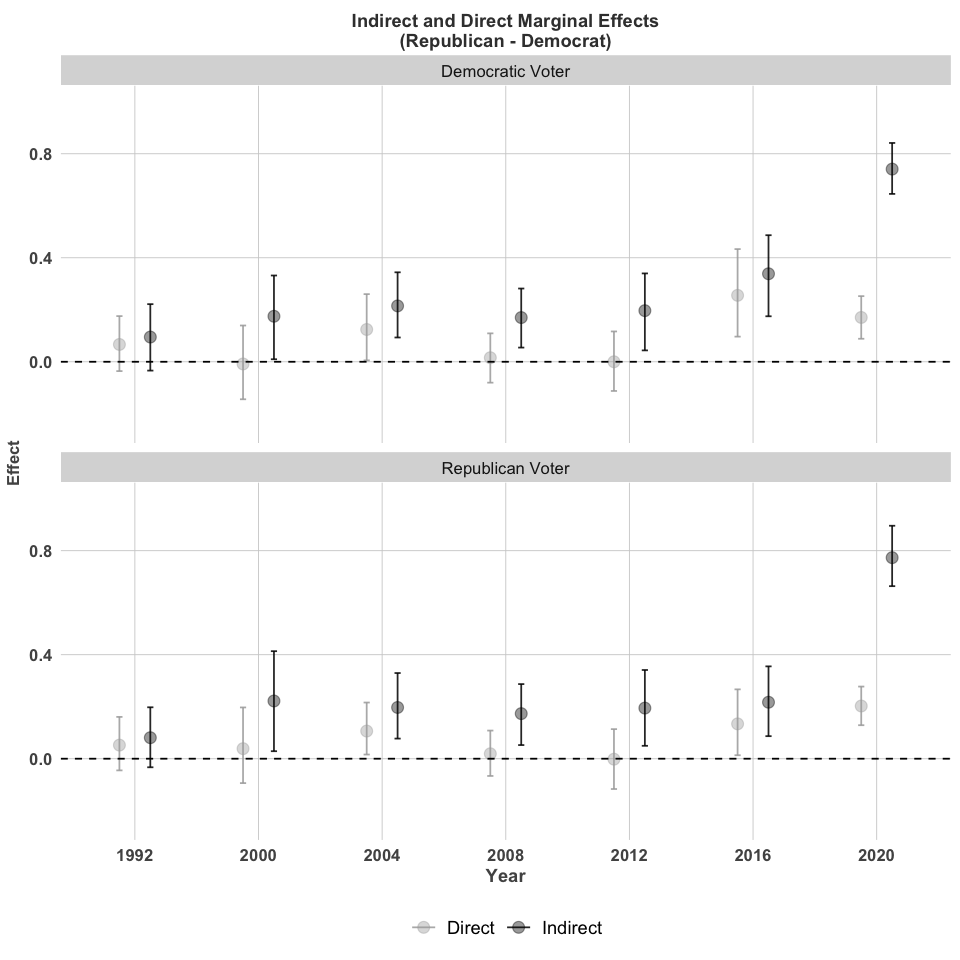

In [215]:
plt <- output[[2]] %>% as.data.frame()
plt$type <- ifelse(grepl("^NIE", row.names(plt)), "Indirect", "Direct")
plt$party <- ifelse(grepl("*_0", row.names(plt)), "Democratic Voter", "Republican Voter")
plt$year <- rep(c(1992, 2000, 2004, 2008, 2012, 2016, 2020), each = 4)

p <- plt %>% ggplot(aes(
  x = factor(year),
  y = mean, ymin = X2.5.,
  ymax = X97.5., colour = as.factor(type), group = as.factor(type)
)) +
  facet_wrap(~party, nrow = 2) +
  geom_point(size = 3, alpha = 0.4, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha = 0.85, position = position_dodge(width = 0.5)) +
  ggtheme +
  ggtitle("Indirect and Direct Marginal Effects\n(Republican - Democrat)") +
  scale_y_continuous("Effect", limits = c(-0.25, 1)) +
  scale_x_discrete("Year") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name = "Type", values = c("darkgrey", "black")) +
  theme(
    plot.title = element_text(size = 11, face = "bold", hjust = 0.5), axis.title = element_text(size = 11),
    axis.text = element_text(size = 11),
    legend.title = element_blank(),
    legend.text = element_text(size = 11),
    legend.position = "bottom"
  )
options(repr.plot.width = 8, repr.plot.height = 8)
p

png("/Users/Chris/Dropbox/github_repos/Authoritarianism_book/authoritarianism_uspolitics/images/f5.5.png", width = 4, height = 6, units = "in", res = 400)
print(p)
dev.off()

In [287]:
output[[2]]

,mean,se_mean,sd,X2.5.,X25.,X50.,X75.,X97.5.,n_eff,Rhat
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
NIE_0,0.7408742,0.001445127,0.05069086,0.64547862,0.7049654,0.7394946,0.7762917,0.8414248,1230.404,1.0004625
NIE_1,0.7730971,0.001634194,0.05838005,0.66350872,0.7326665,0.7705350,0.8130710,0.8958312,1276.209,1.0009445
NDE_0,0.1704087,0.001104128,0.04249129,0.08845995,0.1408379,0.1702452,0.1985815,0.2523499,1481.020,0.9990981
NDE_1,0.2026316,0.000993896,0.03796918,0.12879325,0.1766493,0.2030611,0.2266184,0.2773958,1459.421,0.9994277
NIE_0.1,0.7408742,0.001445127,0.05069086,0.64547862,0.7049654,0.7394946,0.7762917,0.8414248,1230.404,1.0004625
NIE_1.1,0.7730971,0.001634194,0.05838005,0.66350872,0.7326665,0.7705350,0.8130710,0.8958312,1276.209,1.0009445
NDE_0.1,0.1704087,0.001104128,0.04249129,0.08845995,0.1408379,0.1702452,0.1985815,0.2523499,1481.020,0.9990981
NDE_1.1,0.2026316,0.000993896,0.03796918,0.12879325,0.1766493,0.2030611,0.2266184,0.2773958,1459.421,0.9994277
NIE_0.2,0.7408742,0.001445127,0.05069086,0.64547862,0.7049654,0.7394946,0.7762917,0.8414248,1230.404,1.0004625


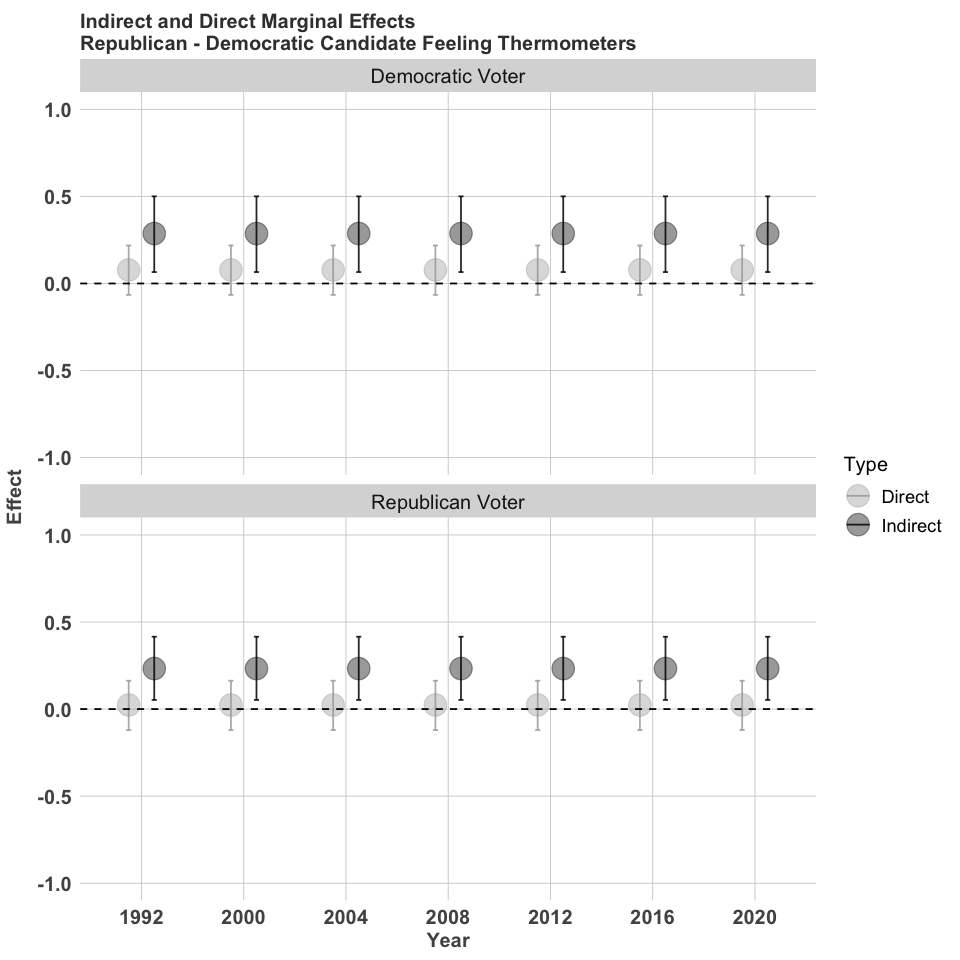

In [282]:
plt = output[[2]]
plt$type = ifelse(grepl("^NIE", row.names(plt)), "Indirect", "Direct")
plt$party = ifelse(grepl("*_0", row.names(plt)), "Democratic Voter", "Republican Voter")
plt$year = rep(c(1992, 2000, 2004, 2008, 2012, 2016, 2020), each =4)
plt %>% ggplot(aes(x = factor(year),
                  y = mean, ymin=X2.5.,
                  ymax=X97.5., colour = as.factor(type), group = as.factor(type)))+ facet_wrap(~party, nrow = 2) +
  geom_point(size=6,  alpha = 0.4, position = position_dodge(width = 0.5)) +
  geom_errorbar(width = 0.10, alpha=0.85, position = position_dodge(width = 0.5)) +
  ggtitle("Indirect and Direct Marginal Effects\nRepublican - Democratic Candidate Feeling Thermometers") +
  ggtheme +
  scale_y_continuous("Effect", limits=c(-1,1)) +
  scale_x_discrete("Year") +
  geom_hline(yintercept = 0, colour = "black", linetype = "dashed") +
  scale_colour_manual(name="Type", values=c("darkgrey", "black")) -> p



p
